In [1]:
import shutil
import os
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path
from collections import OrderedDict

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.optim as optim

In [2]:
torch.cuda.empty_cache()
#사용하지 않으면서 캐시된 메모리들을 해제

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Epoch = 10

### Load Data and Labeling

In [5]:
newpath = Path("./Data").expanduser()

# train_path='./images_original'
train_path = str(newpath.joinpath("testing"))
valid_path = str(newpath.joinpath("valid"))
test_path = str(newpath.joinpath("test"))

In [6]:
# MEANS = [0.485 , 0.456, 0.406]
# DEVIATIONS = [0.229, 0.224 , 0.225]
MEANS=0.5
DEVIATIONS=0.5
# transforms
resize = (64,64)

train_transform = transforms.Compose([
#                     transforms.RandomRotation(20),
                    transforms.Resize(resize),
#                     transforms.CenterCrop((224,224)),
                    
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(MEANS, DEVIATIONS)])

valid_transform = transforms.Compose([
                    transforms.Resize(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(MEANS, DEVIATIONS)])

test_transform = transforms.Compose([
                    transforms.Resize(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(MEANS, DEVIATIONS)])

# # Image folder
train_data = datasets.ImageFolder(root = train_path, transform = train_transform)
validation_data = datasets.ImageFolder(root = valid_path, transform = train_transform)
test_data = datasets.ImageFolder(root = test_path, transform = test_transform)


# DataLoader
train_DataLoader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_DataLoader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=True)
test_DataLoader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
# #데이터셋으로 데이터 로더 만들기

In [7]:
print(f'Train data : {len(train_data)}')
print(f'Validation data : {len(validation_data)}')
print(f'Test data : {len(test_data)}')

Train data : 10136
Validation data : 1561
Test data : 1171


In [8]:
print("train : ",train_data.classes)
print("validation : ",validation_data.classes)
print("test : ",test_data.classes)

train :  ['fake', 'real']
validation :  ['fake', 'real']
test :  ['fake', 'real']


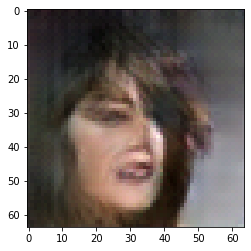

In [9]:
plt.imshow((test_data.__getitem__(50)[0]*0.5+0.5).permute(1,2,0).detach().numpy())

## Model VGG16

In [10]:
model =torchvision.models.vgg16(pretrained=True, progress=True)

for param in model.parameters():
    param.requires_grad = False

fc = nn.Sequential(OrderedDict([
                       ( '(0): Linear',nn.Linear(in_features=25088, out_features=128, bias=True)),
                        ('(1): ReLU',nn.ReLU(inplace=True)),
                        ('(2): Dropout',nn.Dropout(p=0.5, inplace=False)),
                        ('(3): Linear',nn.Linear(in_features=128, out_features=128, bias=True)),
                        #('(4): Sigmoid',nn.Sigmoid()),
                        ('(4): ReLU',nn.ReLU(inplace=True)),
                        ('(5): Dropout', nn.Dropout(p=0.5, inplace=False)),
                        ('(6): Linear',nn.Linear(in_features=128, out_features=len(train_data.classes), bias=True)),
                      ]))

model.classifier = fc
# model = torch.load('./model/0fold_vgg11_1_min.pt')
model.to(device)


# model.apply(init_weights)

print('model prepared')

model prepared


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr =1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,10,0.1)

In [12]:
# 이미지가 깨졌을 경우, 오류 발생X
from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
vali_loss_min = np.inf
train_losses,valid_losses=[],[]
train_Acc,valid_Acc =[],[]
train_lr=[]
for epoch in range(Epoch):
    print(f'{epoch+1}st training start')
    train_accuracy =0
    vali_accuracy = 0
    train_loss ,vali_loss =0,0
    model.train()
    for x, y in tqdm(train_DataLoader):
        x,y = x.to(device), y.to(device)
        output= model(x)
        
        optimizer.zero_grad()
        
        loss = criterion(output, y)
#         loss = my_loss(output, y.long())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*x.size(0)
        
        ps = output.clone().softmax(dim=1)
#         ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_DataLoader):
            x,y = x.to(device), y.to(device)
            output= model(x)
            loss=criterion( output, y)
            
            vali_loss += loss.item()*x.size(0)
            
            ps = output.clone().softmax(dim=1)
#             ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            vali_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    train_loss = train_loss/ len(train_DataLoader.sampler)
    vali_loss = vali_loss/ len(valid_DataLoader.sampler)

    train_accuracy=(train_accuracy/len(train_DataLoader))*100
    vali_accuracy=(vali_accuracy/len(valid_DataLoader))*100


    train_Acc.append(train_accuracy)
    valid_Acc.append(vali_accuracy)
    train_losses.append(train_loss)
    valid_losses.append(vali_loss)
    
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    train_lr.append(learning_rate)
    print(f'learning_rate : {learning_rate:.1e}')
    
    scheduler.step()
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, vali_loss))
    print('          \tTraining Accuracy: {:.2f} \tValidation Accuracy: {:.2f}%'.format( train_accuracy, vali_accuracy))

        
    
    if vali_loss < vali_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( vali_loss_min, vali_loss))
#         torch.save(model, f'vgg16_{cnt}.pt')
        vali_loss_min = vali_loss
    
#         torch.save(model, f'model/vgg16_{epoch+1}_min.pt')
        torch.save(model, f'model/vgg16_simpson_1.pt')
        #torch.save(model, f'model/vgg16_simpson2.pt')
    
#         torch.save(model, f'model/vgg16_mushroom.pt')
    
        
#     else:
#         torch.save(model, f'model/vgg16_{epoch+1}.pt')
        
 

  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

1st training start


  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

learning_rate : 1.0e-03
Epoch: 1 	Training Loss: 0.249996 	Validation Loss: 0.080295
          	Training Accuracy: 90.88 	Validation Accuracy: 97.00%
Validation loss decreased (inf --> 0.080295).  Saving model ...
2st training start


  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

learning_rate : 1.0e-03
Epoch: 2 	Training Loss: 0.140408 	Validation Loss: 0.073114
          	Training Accuracy: 95.02 	Validation Accuracy: 97.34%
Validation loss decreased (0.080295 --> 0.073114).  Saving model ...
3st training start


  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

learning_rate : 1.0e-03
Epoch: 3 	Training Loss: 0.120346 	Validation Loss: 0.066841
          	Training Accuracy: 95.66 	Validation Accuracy: 97.58%
Validation loss decreased (0.073114 --> 0.066841).  Saving model ...
4st training start


  0%|▎                                                                                 | 2/634 [00:00<00:40, 15.61it/s]

learning_rate : 1.0e-03
Epoch: 4 	Training Loss: 0.097882 	Validation Loss: 0.071263
          	Training Accuracy: 96.82 	Validation Accuracy: 97.51%
5st training start


  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

learning_rate : 1.0e-03
Epoch: 5 	Training Loss: 0.102172 	Validation Loss: 0.064874
          	Training Accuracy: 96.33 	Validation Accuracy: 97.77%
Validation loss decreased (0.066841 --> 0.064874).  Saving model ...
6st training start


  0%|▎                                                                                 | 2/634 [00:00<00:44, 14.27it/s]

learning_rate : 1.0e-03
Epoch: 6 	Training Loss: 0.084523 	Validation Loss: 0.071265
          	Training Accuracy: 96.86 	Validation Accuracy: 97.39%
7st training start


  0%|                                                                                          | 0/634 [00:00<?, ?it/s]

learning_rate : 1.0e-03
Epoch: 7 	Training Loss: 0.084533 	Validation Loss: 0.053620
          	Training Accuracy: 97.00 	Validation Accuracy: 98.02%
Validation loss decreased (0.064874 --> 0.053620).  Saving model ...
8st training start


  0%|▎                                                                                 | 2/634 [00:00<00:52, 12.11it/s]

learning_rate : 1.0e-03
Epoch: 8 	Training Loss: 0.081261 	Validation Loss: 0.061362
          	Training Accuracy: 97.14 	Validation Accuracy: 98.15%
9st training start


  0%|▎                                                                                 | 2/634 [00:00<00:45, 13.78it/s]

learning_rate : 1.0e-03
Epoch: 9 	Training Loss: 0.079815 	Validation Loss: 0.070850
          	Training Accuracy: 96.98 	Validation Accuracy: 97.45%
10st training start


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.30it/s]

learning_rate : 1.0e-03
Epoch: 10 	Training Loss: 0.085261 	Validation Loss: 0.069202
          	Training Accuracy: 97.09 	Validation Accuracy: 97.19%


## Model ResNet-50

In [14]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=2, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 2])


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

In [18]:
loss_func= nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters() , lr =0.001)# ,weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,10,0.1)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [19]:
def get_lr(optimizer):
    for param_group in opt.param_groups:
        return param_group['lr']

In [20]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [21]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [22]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()#time 대신 tqdm 사용

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)
        
        #save model
        torch.save(model, f'model/resnet_1.pt')

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [23]:
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_DataLoader,
    'val_dl':valid_DataLoader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')

In [24]:
import time
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/20, current lr=0.001
Get best val_loss
train loss: 0.009858, val loss: 0.001666, accuracy: 98.98, time: 1.1872 min
----------
Epoch 2/20, current lr=0.001
Get best val_loss
train loss: 0.001616, val loss: 0.000771, accuracy: 99.30, time: 2.3768 min
----------
Epoch 3/20, current lr=0.001
Get best val_loss
train loss: 0.001041, val loss: 0.000555, accuracy: 99.68, time: 3.5564 min
----------
Epoch 4/20, current lr=0.001
Get best val_loss
train loss: 0.000890, val loss: 0.000294, accuracy: 99.81, time: 4.7412 min
----------
Epoch 5/20, current lr=0.001
train loss: 0.001002, val loss: 0.001189, accuracy: 99.55, time: 5.9206 min
----------
Epoch 6/20, current lr=0.001
train loss: 0.000813, val loss: 0.000535, accuracy: 99.62, time: 7.1032 min
----------
Epoch 7/20, current lr=0.001
train loss: 0.000589, val loss: 0.000310, accuracy: 99.87, time: 8.2879 min
----------
Epoch 8/20, current lr=0.001
Get best val_loss
train loss: 0.000469, val loss: 0.000165, accuracy: 99.87, time: 9.46

In [25]:
res_1 = torch.load('./model/resnet_1.pt')
res_2 = torch.load('./model/resnet_2.pt')

In [26]:
model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output_0= res_1(x)
        output_1 = res_2(x)
        
        output = (output_0.softmax(dim=1) + output_1.softmax(dim =1))/2
        
        loss=criterion(output, y)

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 27.50it/s]

Test_Accuracy : 50.68027210884354


## Model Efficientnet

In [27]:
import copy

class Swish(nn.Module): 
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

# check
if __name__ == '__main__':
    x = torch.randn(3, 3, 224, 224)
    model = Swish()
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 3, 224, 224])


In [28]:
class SEBlock(nn.Module): 
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 56, 17, 17)
    model = SEBlock(x.size(1))
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 56, 1, 1])


In [29]:
class MBConv(nn.Module): 
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [30]:
class MBConv1(MBConv):
  def __init__(self, n_in, n_out, kernel_size=3,
               stride=1, r=24, p=0):
    super().__init__(n_in, n_out, expansion_factor=1,
                     kernel_size=kernel_size, stride=stride,
                     r=r, p=p)
    
 
class MBConv6(MBConv):
  def __init__(self, n_in, n_out, kernel_size=3,
               stride=1, r=24, p=0):
    super().__init__(n_in, n_out, expansion_factor=6,
                     kernel_size=kernel_size, stride=stride,
                     r=r, p=p)

In [31]:
class SepConv(nn.Module): 
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    # stochastic depth check
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [32]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)


# check
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.randn(3, 3, 224, 224).to(device)
    model = efficientnet_b0().to(device)
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 2])


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr =1e-3)# ,weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,10,0.1)

In [34]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    #save model    
    torch.save(model, f'model/Efficent_1.pt')
    
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [35]:
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_DataLoader,
    'val_dl':valid_DataLoader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [36]:
import time
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/10, current lr= 0.01
Copied best model weights!
train loss: 0.134578, val loss: 0.042642, accuracy: 98.98, time: 1.1858 min
----------
Epoch 2/10, current lr= 0.01
Copied best model weights!
train loss: 0.027236, val loss: 0.010372, accuracy: 99.68, time: 2.4373 min
----------
Epoch 3/10, current lr= 0.01
train loss: 0.015030, val loss: 0.020035, accuracy: 99.49, time: 3.6767 min
----------
Epoch 4/10, current lr= 0.01
train loss: 0.015252, val loss: 0.018265, accuracy: 99.42, time: 4.9185 min
----------
Epoch 5/10, current lr= 0.01
Copied best model weights!
train loss: 0.021049, val loss: 0.000946, accuracy: 100.00, time: 6.1674 min
----------
Epoch 6/10, current lr= 0.01
train loss: 0.020024, val loss: 0.013151, accuracy: 99.49, time: 7.4090 min
----------
Epoch 7/10, current lr= 0.01
train loss: 0.011429, val loss: 0.015459, accuracy: 99.36, time: 8.6758 min
----------
Epoch 8/10, current lr= 0.01
train loss: 0.006384, val loss: 0.146711, accuracy: 97.76, time: 9.9662 min
-

In [37]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    #save model    
    torch.save(model, f'model/Efficent_2.pt')
    
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [38]:
import time
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/10, current lr= 0.01
Copied best model weights!
train loss: 0.100431, val loss: 0.015428, accuracy: 99.36, time: 1.2762 min
----------
Epoch 2/10, current lr= 0.01
Copied best model weights!
train loss: 0.014318, val loss: 0.003719, accuracy: 99.87, time: 2.5486 min
----------
Epoch 3/10, current lr= 0.01
train loss: 0.012521, val loss: 0.013054, accuracy: 99.30, time: 3.8244 min
----------
Epoch 4/10, current lr= 0.01
Copied best model weights!
train loss: 0.006160, val loss: 0.003065, accuracy: 99.87, time: 5.0870 min
----------
Epoch 5/10, current lr= 0.01
Copied best model weights!
train loss: 0.006775, val loss: 0.002191, accuracy: 99.94, time: 6.3714 min
----------
Epoch 6/10, current lr= 0.01
Loading best model weights!
train loss: 0.010690, val loss: 0.026014, accuracy: 99.23, time: 7.6611 min
----------
Epoch 7/10, current lr= 0.001
train loss: 0.004351, val loss: 0.004691, accuracy: 99.87, time: 8.9437 min
----------
Epoch 8/10, current lr= 0.001
train loss: 0.001710,

In [39]:
eff_1 = torch.load('./model/Efficent_1.pt')
eff_2 = torch.load('./model/Efficent_2.pt')

In [40]:
model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output = eff_1(x)
        output_effi = eff_2(x)
        
        output = (output+output_effi)/2
        output = output.softmax(dim = 1)
        #output = eff_2(x)
        loss=criterion( output, y)

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:03<00:00, 42.57it/s]

Test_Accuracy : 50.87868482077202


In [41]:
output.shape

torch.Size([3, 2])

## Accuracy

In [42]:
vgg_1 = torch.load('./model/vgg16_simpson.pt')
vgg_2 = torch.load('./model/vgg16_simpson2.pt')

### vgg16_Test Accuracy 

In [43]:
model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output = vgg_1(x)
        output_effi = vgg_2(x)

        output = (output+output_effi)/2
        output = output.softmax(dim = 1)
        
        loss=criterion( output, y)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:02<00:00, 66.19it/s]

Test_Accuracy : 50.45351475274482


### Efficient_Test Accuracy 

In [44]:
model_1 = torch.load('./model/Efficent_1.pt')
model_2 = torch.load('./model/Efficent_2.pt')

In [45]:
model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output = model_1(x)
        output_effi = model_2(x)

        output = (output+output_effi)/2
        output = output.softmax(dim = 1)
        
        loss=criterion( output, y)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:03<00:00, 43.18it/s]

Test_Accuracy : 50.736961458005055


## Ensemble

In [46]:
model_1 = torch.load('./model/vgg16_simpson_1.pt')
model_2 = torch.load('./model/vgg16_simpson2.pt')

model_3 = torch.load('./model/resnet_1.pt')
model_4 = torch.load('./model/resnet_2.pt')

model_5 = torch.load('./model/Efficent_1.pt')
model_6 = torch.load('./model/Efficent_2.pt')

In [47]:
model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output1 = model_1(x)
        output2 = model_2(x)
        output3 = model_3(x)
        output4 = model_4(x)
        output5 = model_5(x)
        output6 = model_6(x)
        
        
        output = (output1+output2+output3+output4+output5+output6)/6
        output = output.softmax(dim =1)

        
        loss=criterion(output, y)

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:06<00:00, 22.97it/s]

Test_Accuracy : 50.96371883437747


In [48]:
model_1 = torch.load('./model/vgg16_simpson_1.pt')

model.eval()
Test_ACC = 0
with torch.no_grad():
    for x, y in tqdm(test_DataLoader):
#     for x, y in test_DataLoader:
            
        x,y = x.to(device), y.to(device)
        output = model_1(x)
        
        output = output.softmax(dim = 1)
        
        loss=criterion( output, y)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        Test_ACC += torch.mean(equals.type(torch.FloatTensor)).item()
        

Test_ACC=(Test_ACC/len(test_DataLoader))*100

print(f'Test_Accuracy : {Test_ACC}')


100%|███████████████████████████████████████████████████████████████████████████████| 147/147 [00:01<00:00, 101.85it/s]

Test_Accuracy : 61.84807257587407


## Result

In [49]:
classes = ['fake','real']

In [50]:
import torch.nn.functional as F
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(10)
class_total = torch.zeros(10)

model.eval()
# iterate over test data
for data, labels in test_DataLoader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_DataLoader)
test_acc = test_acc/len(test_DataLoader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))

Test Loss: 7.837883

Test Accuracy: 0.506519

Test Accuracy of  fake:  1% ( 6/581)
Test Accuracy of  real: 99% (588/590)


In [51]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

IndexError: index 8 is out of bounds for dimension 0 with size 8

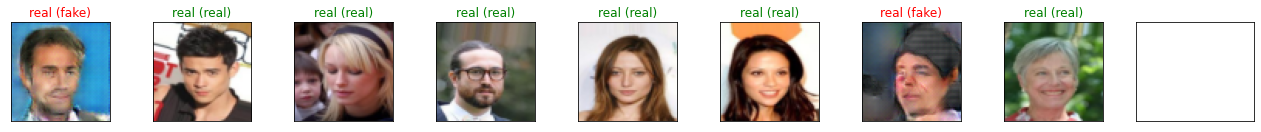

In [52]:
# obtain one batch of test images
dataiter = iter(test_DataLoader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))